# Car Regression Project

In this project, I will predict the price of the used car based on the other features on the dataset. I found the dataset on https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes?select=vw.csv

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("ford.csv")
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0


## Exploratory Data Analysis

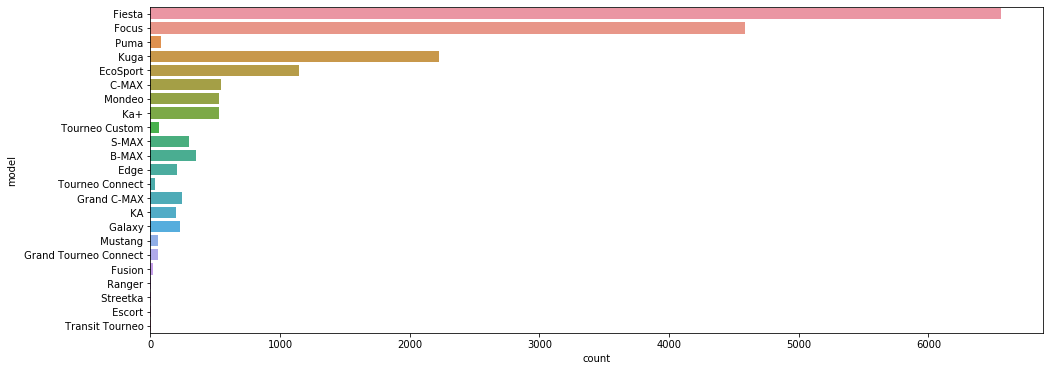

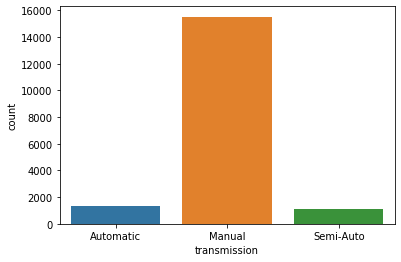

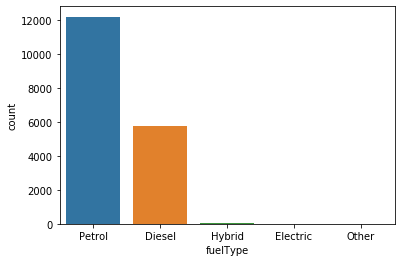

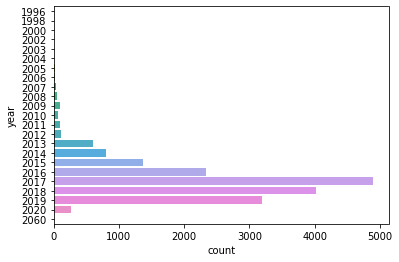

In [2]:
plt.figure(figsize=(16, 6))
sns.countplot(y="model", data=df)
plt.show()
sns.countplot(x="transmission", data=df)
plt.show()
sns.countplot(x="fuelType", data=df)
plt.show()
sns.countplot(y="year", data=df)
plt.show()

It is quite weird that we have a data point with the year 2060. Let's see what is going on here.

In [3]:
print(df[df["year"] == 2060])
print(len(df))

         model  year  price transmission  mileage fuelType  tax   mpg  \
17726   Fiesta  2060   6495    Automatic    54807   Petrol  205  42.8   

       engineSize  
17726         1.4  
17965


It seems like the year is entered wrong. Let's delete this data point.

In [4]:
df = df.drop([17726])
print(df[df["year"] == 2060])
print(len(df))

Empty DataFrame
Columns: [model, year, price, transmission, mileage, fuelType, tax, mpg, engineSize]
Index: []
17964


In [5]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,17964.000000,17964.000000,17964.000000,17964.000000,17964.000000,17964.000000
mean,2016.864173,12280.078435,23361.880149,113.329437,57.907832,1.350824
std,2.024987,4741.318119,19471.243292,62.008392,10.125632,0.432383
min,1996.000000,495.000000,1.000000,0.000000,20.800000,0.000000
25%,2016.000000,8999.000000,9987.000000,30.000000,52.300000,1.000000
50%,2017.000000,11291.000000,18242.500000,145.000000,58.900000,1.200000
75%,2018.000000,15299.000000,31052.000000,145.000000,65.700000,1.500000
max,2020.000000,54995.000000,177644.000000,580.000000,201.800000,5.000000


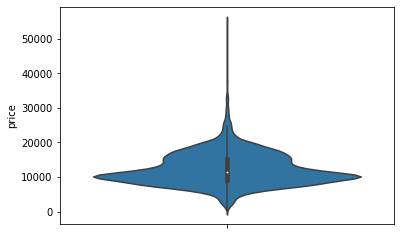

In [6]:
#plot the distribution of the DV price
sns.violinplot(data=df, y="price")
plt.show()

Text(0.5, 1, 'Correlation Heatmap')

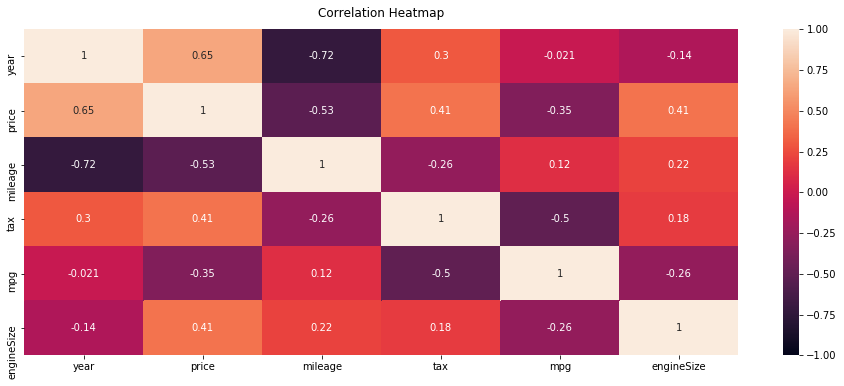

In [7]:
newdf = df.select_dtypes(include=np.number)

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(newdf.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

It seems that year and mileage are the most correlated with the price of the car. Let's put the relationships between these two variables and the car price in graph.

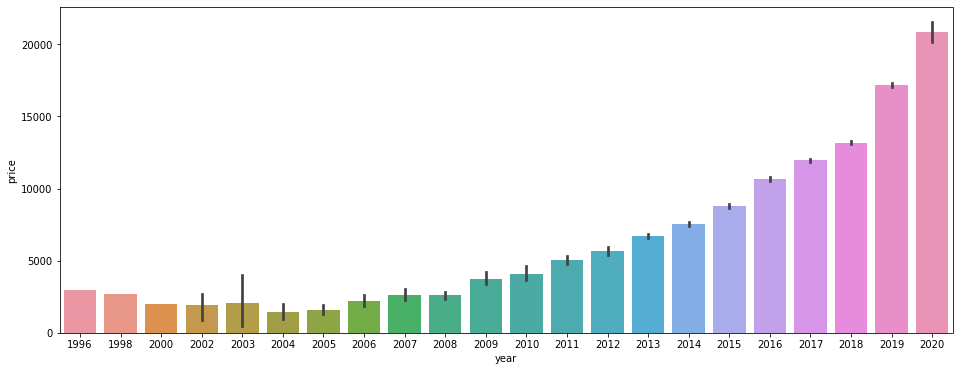

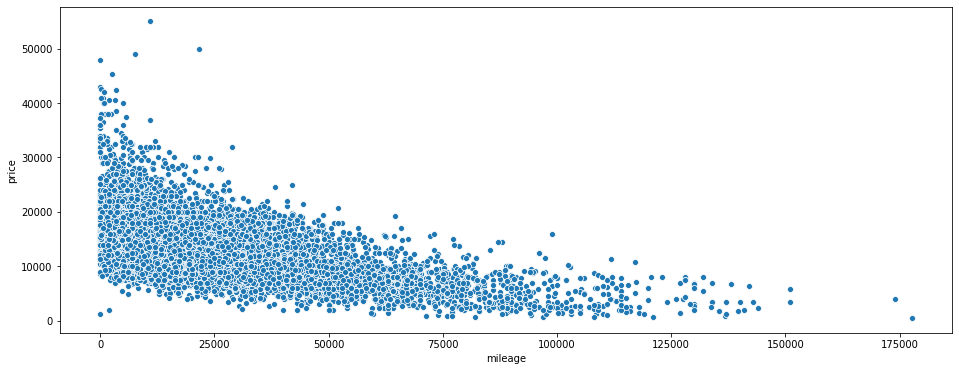

In [8]:
plt.figure(figsize=(16, 6))
sns.barplot(data=df, x="year", y="price")
plt.show()

plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x="mileage", y="price")
plt.show()

## Preprocessing

First, let's see if there are missing values in the dataset.

In [9]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(50))

              Total  Percent
engineSize        0      0.0
mpg               0      0.0
tax               0      0.0
fuelType          0      0.0
mileage           0      0.0
transmission      0      0.0
price             0      0.0
year              0      0.0
model             0      0.0


There are none! Now, let's turn the year variable into an age variable and the categorical variables into dummies.

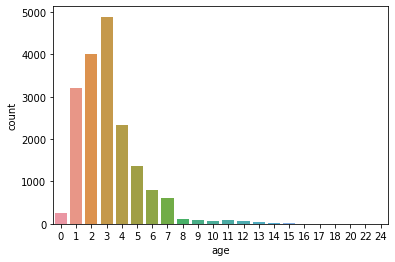

In [10]:
df['age'] = df.year.apply(lambda x: 2020 - x)
del df["year"]
sns.countplot(x="age", data=df)
plt.show()

In [11]:
df = pd.get_dummies(df)
print(df.columns)
print(len(df.columns))

Index(['price', 'mileage', 'tax', 'mpg', 'engineSize', 'age', 'model_ B-MAX',
       'model_ C-MAX', 'model_ EcoSport', 'model_ Edge', 'model_ Escort',
       'model_ Fiesta', 'model_ Focus', 'model_ Fusion', 'model_ Galaxy',
       'model_ Grand C-MAX', 'model_ Grand Tourneo Connect', 'model_ KA',
       'model_ Ka+', 'model_ Kuga', 'model_ Mondeo', 'model_ Mustang',
       'model_ Puma', 'model_ Ranger', 'model_ S-MAX', 'model_ Streetka',
       'model_ Tourneo Connect', 'model_ Tourneo Custom',
       'model_ Transit Tourneo', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel',
       'fuelType_Electric', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol'],
      dtype='object')
37


Finally, I will normalize the data with the sklearn MinMaxScaler.

In [12]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
df = pd.DataFrame(scaled, columns = df.columns)
df.head()

,price,mileage,tax,mpg,engineSize,age,model_ B-MAX,model_ C-MAX,model_ EcoSport,model_ Edge,...,model_ Tourneo Custom,model_ Transit Tourneo,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,0.211101,0.089747,0.258621,0.203867,0.2,0.125000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.247798,0.051125,0.258621,0.203867,0.2,0.083333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.229450,0.070113,0.258621,0.203867,0.2,0.125000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.312018,0.058877,0.250000,0.107735,0.3,0.041667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.293670,0.008337,0.250000,0.154144,0.2,0.041667,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Model Building

I have used the code of https://www.kaggle.com/gireeshs/volkswagen-price-regression-r-2-0-9555 as a tutorial for how to use the sklearn SelectKBest() method to select the best features for the model.

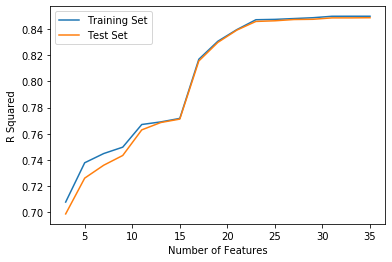

In [13]:
y = df["price"]
X = df
del X["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

no_of_features = []
r_squared_train = []
r_squared_test = []

for k in range(3, len(X.columns), 2):
    selector = SelectKBest(f_regression, k=k)
    X_train_transformed = selector.fit_transform(X_train, y_train)
    X_test_transformed = selector.transform(X_test)
    regressor = LinearRegression()
    regressor.fit(X_train_transformed, y_train)
    no_of_features.append(k)
    r_squared_train.append(regressor.score(X_train_transformed, y_train))
    r_squared_test.append(regressor.score(X_test_transformed, y_test))
    
sns.lineplot(x=no_of_features, y=r_squared_train)
sns.lineplot(x=no_of_features, y=r_squared_test)
plt.legend(["Training Set", "Test Set"])
plt.xlabel("Number of Features")
plt.ylabel("R Squared")
plt.show()

The curve stabilizes around 22 features, when R squared is 0.84. Hence, I will use the 23 best features.

In [14]:
selector = SelectKBest(f_regression, k=23)
X_train_transformed = selector.fit_transform(X_train, y_train)
X_test_transformed = selector.transform(X_test)
column_names = X_train.columns
print(column_names[selector.get_support()])

Index(['mileage', 'tax', 'mpg', 'engineSize', 'age', 'model_ B-MAX',
       'model_ C-MAX', 'model_ Edge', 'model_ Fiesta', 'model_ Focus',
       'model_ Galaxy', 'model_ KA', 'model_ Ka+', 'model_ Kuga',
       'model_ Mustang', 'model_ Puma', 'model_ S-MAX',
       'model_ Tourneo Custom', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel',
       'fuelType_Petrol'],
      dtype='object')


In [15]:
def regression_model(model):
    model.fit(X_train_transformed, y_train)
    train_score = model.score(X_train_transformed, y_train)
    test_score = model.score(X_test_transformed, y_test)
    return model, train_score, test_score

model_performance = pd.DataFrame(columns = ["Model", "Training R2 Score", "Test R2 Score"])
regressors = []
models_to_evaluate = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(), XGBRegressor()]
for model in models_to_evaluate:
    regressor, train_score, test_score = regression_model(model)
    model_performance = model_performance.append({"Model": model, "Training R2 Score": train_score, "Test R2 Score": test_score}, ignore_index=True)
model_performance

,Model,Training R2 Score,Test R2 Score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.847085,0.845784
1,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.846974,0.845556
2,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",0.752893,0.760946
3,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.989729,0.927744
4,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.964563,0.938088


I can see that the gradient boosted regression tree is the best working model with an R2 score of 0.938. This model explains almost 94% of the variance in the dependent variable! Let's see what the importance is of the different features for this model. 

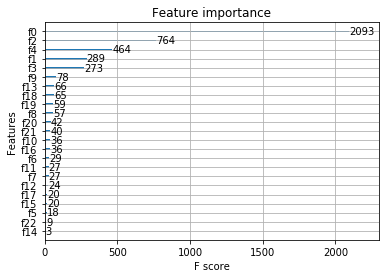

In [16]:
from xgboost import plot_importance

model, train_score, test_score = regression_model(XGBRegressor())
plot_importance(model)
plt.show()

The most important feature is by far f0 (which is mileage, how many miles are travelled with this car). After mileage are respectively mpg (miles per gallon), age, tax and engineSize. Let's see if the models do better when new features are generated by adding polynomials and interactions.

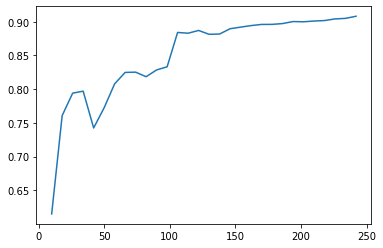

,Model,Training R2 Score,Test R2 Score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.910372,0.881294
1,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",0.899071,0.895889
2,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",0.753114,0.756575
3,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.989408,0.928137
4,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.968581,0.936227


In [17]:
poly = PolynomialFeatures()
X_train_transformed_poly = poly.fit_transform(X_train)
X_test_transformed_poly = poly.transform(X_test)

no_of_features = []
r_squared = []

for k in range(10, 250, 8):
    selector = SelectKBest(f_regression, k=k)
    X_train_transformed = selector.fit_transform(X_train_transformed_poly, y_train)
    X_test_transformed = selector.transform(X_test_transformed_poly)
    regressor = LinearRegression()
    regressor.fit(X_train_transformed, y_train)
    no_of_features.append(k)
    r_squared.append(regressor.score(X_test_transformed, y_test))
    
sns.lineplot(x=no_of_features, y=r_squared)
plt.show()

selector = SelectKBest(f_regression, k = 130)
X_train_transformed = selector.fit_transform(X_train_transformed_poly, y_train)
X_test_transformed = selector.transform(X_test_transformed_poly)

model_performance = pd.DataFrame(columns = ["Model", "Training R2 Score", "Test R2 Score"])
models_to_evaluate = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(), XGBRegressor()]
for model in models_to_evaluate:
    regressor, train_score, test_score = regression_model(model)
    model_performance = model_performance.append({"Model": model, "Training R2 Score": train_score, "Test R2 Score": test_score}, ignore_index=True)
model_performance

Because of the polynomial transformation, the Linear Regression and Ridge models perform much better, but the SVR and tree models do not.

## Conclusion

- The gradient boosted regression tree without polynomial transformation performs best to predict the price of the used cars. The most important features for this model are mileage (the amount of miles travelled with the car), mpg (miles per gallon) and age, which all have a negative correlation with the car price.